<a href="https://colab.research.google.com/github/hazelkozlu/CoreDemo/blob/master/makaleinceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#google drive bağlantısı için
from  google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Colab Notebooks/

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Veri yolu ve parametreleri

train_data_dir = 'TezVeriSeti/train'
test_data_dir = 'TezVeriSeti/valid'
img_width, img_height = 224, 224   # Inception V3 giriş boyutu
batch_size = 32
epochs = 20  # Increase the number of epochs
num_classes = 4

# Veri Ön İşleme
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(test_data_dir,
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

# Inception V3 Modeli Oluşturma
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Yeni sınıflandırma katmanını ekleyelim
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

# Modeli birleştirelim
model = models.Model(inputs=base_model.input, outputs=predictions)

# İlk katmanları dondurarak transfer öğrenmeyi etkinleştirelim
for layer in base_model.layers:
    layer.trainable = False

# Modeli derleme
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size)




Found 958 images belonging to 4 classes.
Found 960 images belonging to 4 classes.
87910968/87910968 [==============================] - 1s 0us/step


Epoch 1/20
29/29 [==============================] - 654s 23s/step - loss: 1.6163 - accuracy: 0.5313 - val_loss: 0.7286 - val_accuracy: 0.6677
Epoch 2/20
29/29 [==============================] - 274s 10s/step - loss: 0.5673 - accuracy: 0.7678 - val_loss: 0.5905 - val_accuracy: 0.7625
Epoch 3/20
29/29 [==============================] - 279s 10s/step - loss: 0.4801 - accuracy: 0.8110 - val_loss: 0.5460 - val_accuracy: 0.7719
Epoch 4/20
29/29 [==============================] - 275s 10s/step - loss: 0.4133 - accuracy: 0.8315 - val_loss: 0.4762 - val_accuracy: 0.8000
Epoch 5/20
29/29 [==============================] - 278s 10s/step - loss: 0.3629 - accuracy: 0.8553 - val_loss: 0.4686 - val_accuracy: 0.8167
Epoch 6/20
29/29 [==============================] - 269s 9s/step - loss: 0.3789 - accuracy: 0.8499 - val_loss: 0.5051 - val_accuracy: 0.7875
Epoch 7/20
29/29 [==============================] - 274s 10s/step - loss: 0.3512 - accuracy: 0.8683 - val_loss: 0.4429 - val_accuracy: 0.8281
Epoch 8

In [4]:
# Modeli değerlendirme
test_loss, test_accuracy = model.evaluate(validation_generator, steps=len(validation_generator))
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


# Modeli kaydetme
model.save('inception_v3_model.h5')
print("Model başarıyla kaydedildi.")

# Yeni görüntüleri tahmin etme
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_leaf_disease(image_path):
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Tahmin
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction[0])   # En yüksek olasılığa sahip sınıfın dizini
    class_labels = train_generator.class_indices   # Sınıf etiketlerini alın
    class_label = list(class_labels.keys())[list(class_labels.values()).index(class_index)]   # Sınıf etiketini alın
    print(f"Tahmin: {class_label}, Olasılık: {prediction[0][class_index]}")

# Test için yeni bir görüntü tahmini
##test_image_path = 'TezVeriSeti/valid/yaprakdelen/delendog (1).png'
test_image_path = 'TezVeriSeti/test1/test - Kopya/IMG_20220703_130251-256 b1 (145).png'

predict_leaf_disease(test_image_path)

30/30 [==============================] - 135s 5s/step - loss: 0.3955 - accuracy: 0.8646
Test Loss: 0.3955181837081909, Test Accuracy: 0.8645833134651184
Model başarıyla kaydedildi.
1/1 [==============================] - 2s 2s/step
Tahmin: yaprakdelen, Olasılık: 0.999733030796051


In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Test verileri üzerinde modeli değerlendirme
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Modelin tahminleri
y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size)
y_pred_classes = np.argmax(y_pred, axis=1)  # Sınıf indekslerine dönüştürme

# Gerçek etiketler
y_true = test_generator.classes

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Sınıflandırma Raporunu yazdırma
target_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=target_names))


Found 960 images belonging to 4 classes.
30/30 [==============================] - 127s 4s/step
Confusion Matrix:
[[239   0   1   0]
 [  0 213   6  21]
 [  0  13 193  34]
 [  0  28  27 185]]

Classification Report:
               precision    recall  f1-score   support

      kulleme       1.00      1.00      1.00       240
potasyumeksik       0.84      0.89      0.86       240
     saglikli       0.85      0.80      0.83       240
  yaprakdelen       0.77      0.77      0.77       240

     accuracy                           0.86       960
    macro avg       0.86      0.86      0.86       960
 weighted avg       0.86      0.86      0.86       960



Found 960 images belonging to 4 classes.
30/30 [==============================] - 129s 4s/step
Confusion Matrix:
[[239   0   1   0]
 [  0 213   6  21]
 [  0  13 193  34]
 [  0  28  27 185]]


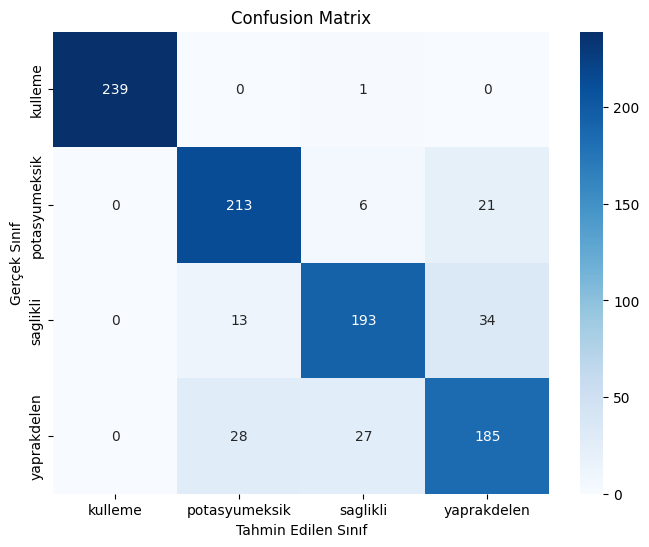


Classification Report:
               precision    recall  f1-score   support

      kulleme       1.00      1.00      1.00       240
potasyumeksik       0.84      0.89      0.86       240
     saglikli       0.85      0.80      0.83       240
  yaprakdelen       0.77      0.77      0.77       240

     accuracy                           0.86       960
    macro avg       0.86      0.86      0.86       960
 weighted avg       0.86      0.86      0.86       960



In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Test verileri üzerinde modeli değerlendirme
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Modelin tahminleri
y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size)
y_pred_classes = np.argmax(y_pred, axis=1)  # Sınıf indekslerine dönüştürme

# Gerçek etiketler
y_true = test_generator.classes

# Confusion Matrix'i hesapla
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Confusion Matrix'i görselleştirme
class_labels = list(test_generator.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Confusion Matrix')
plt.show()

# Sınıflandırma Raporunu yazdırma
target_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=target_names))
